# Summary

With the outbreak of the Covid-19 virus, one of the major symptoms being detected in patients is Pneumonia. This has led to an increased need in detecting patients who have pneumonia with high accuracy. 
In this project I have classified Chest X-ray images into Normal patients and Pneumonia patients using this
[dataset](https://www.kaggle.com/pcbreviglieri/pneumonia-xray-images) , which is an adapted version of Paul Mooney's 'Chest X-Ray Images (Pneumonia)' [dataset](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia).

**This adapted dataset is split into Training, Validation and Testing Observations as follows:**

Training set: 4,192 (1,082 normal, 3,110 pneumonia);

Validation set: 1,040 (267 normal, 773 pneumonia);

Testing set: 624 (234 normal, 390 pneumonia)

I have achieved an accuracy **above 90%** in successfully classifying those images.

For this project I have used Google Colab for executing my code in a GPU-based runtime environment. 



# Installing kaggle dataset into Colab 

In [0]:
!pip install kaggle

In [1]:
from google.colab import files
files.upload() #choose files to upload in dropbox

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kartiknair","key":"efce4c669ce529b6cc65741d7d08d9ed"}'}

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
#Change the permission
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d pcbreviglieri/pneumonia-xray-images

 99% 1.13G/1.14G [00:32<00:00, 41.4MB/s]
100% 1.14G/1.14G [00:32<00:00, 37.9MB/s]


In [7]:
#Extracting the zip file to download the csv files
from zipfile import ZipFile
file_name="pneumonia-xray-images.zip"
with ZipFile(file_name,'r') as zip:
  print('Extracting file...')
  zip.extractall()
  print('Done')

Extracting file...
Done


# Importing required Libraries

In [9]:
import numpy as np # forlinear algebra
import matplotlib.pyplot as plt #for plotting
import pandas as pd
import os
from PIL import Image

# Importing Keras Libraries for building CNN model
import keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.metrics import classification_report, confusion_matrix

Using TensorFlow backend.


# Exploring the dataset

In [10]:
print(os.listdir('/content'))

['.config', 'test', 'train', 'kaggle.json', 'val', '.ipynb_checkpoints', 'pneumonia-xray-images.zip', 'sample_data']


In [0]:
train_dir='/content/train/'
test_dir='/content/test/'
val_dir='/content/val/'

In [12]:
#will show names of the two files inside
os.listdir(train_dir) 

['opacity', 'normal']

In [0]:
#two different ways to move inside directories
train_n = train_dir + 'normal/'
train_p = os.path.join(train_dir,'opacity/')

In [15]:
#Number of images in both cases
print('Total Normal images in training set:',len(os.listdir(train_n)))
print('Total Pneumonia images in training set:',len(os.listdir(train_p)))

Total Normal images in training set: 1082
Total Pneumonia images in training set: 3110


**We can see that number of sample images for normal patients is less than number of pneumonia detected patients.
We will use data augmentation later to reduce overfitting.**

**For now, we will look at samples of both the normal images and the pneumonia images**

Title of normal picture:  IM-0663-0001.jpeg
Title of pneumonia picture: person1323_bacteria_3362.jpeg


Text(0.5, 1.0, 'Pneumonia')

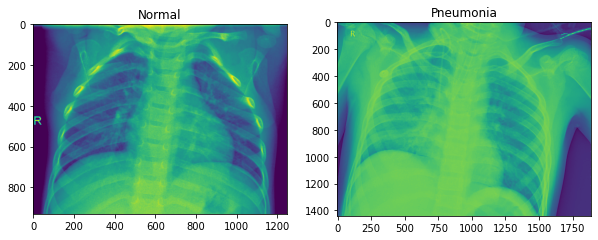

In [17]:
#Selecting random Normal pic 
n_random= np.random.randint(0,len(os.listdir(train_n)))
n_pic = os.listdir(train_n)[n_random]
print('Title of normal picture: ',n_pic)
n_pic_addr = train_n + n_pic
#Selecting random Pneumonia pic
p_rand = np.random.randint(0,len(os.listdir(train_p)))
pneum_pic =  os.listdir(train_p)[p_rand]
print('Title of pneumonia picture:', pneum_pic)
pneum_pic_addr = train_p + pneum_pic
## Loading the images
n_load = Image.open(n_pic_addr)
pneum_load = Image.open(pneum_pic_addr)
## Plotting images
fig = plt.figure(figsize= (10,8))
p1 = fig.add_subplot(1,2,1)
img_plot = plt.imshow(n_load)
p1.set_title('Normal')

p2 = fig.add_subplot(1, 2, 2)
img_plot = plt.imshow(pneum_load)
p2.set_title('Pneumonia')

**We observe that the right image has an increased opacity which reltaes to higher chances of having pneumonia.**

We will rescale those images and convert the images into grayscale before fitting the images to the model.

# Data Augmentation

Before feeding our data to the model we need to do  rescaling, rotation, shearing and zooming.

In [0]:
training_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip = True, shear_range=0.2, zoom_range=0.2)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

Now we will load the dataset using "flow_from_directory" function.

In [33]:
training_set = training_datagen.flow_from_directory('/content/train/',
                                                    target_size = (64, 64),
                                                    batch_size = 16,
                                                    class_mode = 'binary',
                                                    color_mode='grayscale')

valid_set = valid_datagen.flow_from_directory('/content/val/',
                                              target_size=(64, 64),
                                              batch_size=16,
                                              class_mode='binary',
                                              color_mode='grayscale')
test_set = test_datagen.flow_from_directory('/content/test',
                                            target_size = (64, 64),
                                            batch_size = 1,
                                            class_mode = None,
                                            color_mode='grayscale',
                                            shuffle=False)

Found 4192 images belonging to 2 classes.
Found 1040 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# Building the CNN Model

I have built a CNN with 2 Convolution layers with non linear activation funcition(ReLU). I have also added a Pooling layer(MaxPooling) after each convolution layer. At the output of the second convolutional layer we get a feature map which we will pass through two fully connected layers to make predictions.

In [0]:
cnn = Sequential()

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(64, 64, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(32, (3, 3), activation="relu"))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Flatten())

cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'sigmoid', units = 1))

cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [21]:
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               802944    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [43]:
cnn_model = cnn.fit_generator(training_set,
                              steps_per_epoch = 4192//16,
                              epochs = 10,
                              validation_data = valid_set,
                              validation_steps = 64)

Epoch 1/10
262/262 [==============================] - 45s 170ms/step - loss: 0.0890 - accuracy: 0.9678 - val_loss: 0.0727 - val_accuracy: 0.9492
Epoch 2/10
262/262 [==============================] - 44s 168ms/step - loss: 0.0811 - accuracy: 0.9716 - val_loss: 0.1274 - val_accuracy: 0.9541
Epoch 3/10
262/262 [==============================] - 43s 163ms/step - loss: 0.0776 - accuracy: 0.9711 - val_loss: 0.0253 - val_accuracy: 0.9443
Epoch 4/10
262/262 [==============================] - 43s 164ms/step - loss: 0.0766 - accuracy: 0.9695 - val_loss: 0.2398 - val_accuracy: 0.9561
Epoch 5/10
262/262 [==============================] - 43s 165ms/step - loss: 0.0777 - accuracy: 0.9728 - val_loss: 0.0872 - val_accuracy: 0.9521
Epoch 6/10
262/262 [==============================] - 43s 164ms/step - loss: 0.0793 - accuracy: 0.9695 - val_loss: 0.0240 - val_accuracy: 0.9375
Epoch 7/10
262/262 [==============================] - 43s 163ms/step - loss: 0.0720 - accuracy: 0.9738 - val_loss: 0.0121 - val_ac

# Predicting on the Test set

**We will predict the class to which the images from test set belong to. We will get an array with values between 0 and 1, which we will round of to its nearest integer value(Normal = 0 and Pneumonia = 1).**

In [0]:
Y_pred = cnn.predict_generator(test_set)
y_pred = np.round(Y_pred, decimals=0)

**Now that we have the predicted output vector with us, we will calculate the accuracy of our model using Confusion matrix and Classification Report.**

In [45]:
print('Confusion Matrix')
conf_mat = pd.DataFrame(data=confusion_matrix(test_set.classes, y_pred, labels=[0, 1]),
                        index=["Actual Normal", "Actual Pneumonia"],
                        columns=["Predicted Normal", "Predicted Pneumonia"])
conf_mat

Confusion Matrix


,Predicted Normal,Predicted Pneumonia
Actual Normal,182,52
Actual Pneumonia,7,383


In [46]:
print('Classification Report')
target_names = ['Normal','Pneumonia']
print(classification_report(test_set.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

      Normal       0.96      0.78      0.86       234
   Pneumonia       0.88      0.98      0.93       390

    accuracy                           0.91       624
   macro avg       0.92      0.88      0.89       624
weighted avg       0.91      0.91      0.90       624



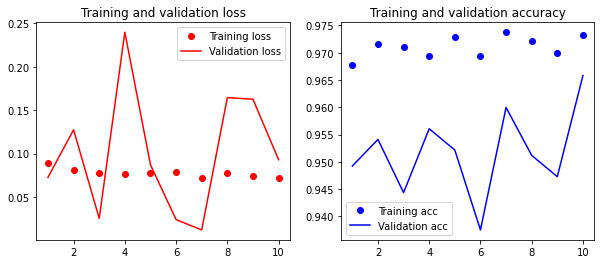

In [47]:
acc = cnn_model.history['accuracy']
val_acc = cnn_model.history['val_accuracy']
loss = cnn_model.history['loss']
val_loss = cnn_model.history['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10,4))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()